In [47]:
# Lax Hopf Implementation

import numpy as np
import matplotlib.pyplot as plt

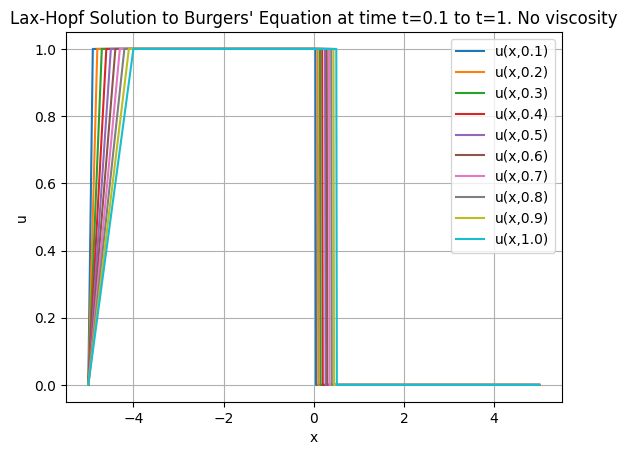

In [ ]:
# Burgers' Equation

# discretized spatial grid
X = np.linspace(-5, 5, 801)
Y = X.copy()

# inital conditions u0 (Reimann problem with uL > uR)
def u0(y):
    return 1.0 * (y - 0.0) if y < 0 else 0.0

# Legendre transform L(v) = v^2 / 2 for Burgers' equation
def L(v):
    return (0.5 * v**2)

# Lax-Hopf formula for Burgers' equation
def lax_hopf_burgers(u0, L, X, t, Y):
    '''
    u0: initial conditions u0(y)
    L: Legendre transform function L(y)
    X: discrete grid of space
    t: time
    Y: discrete grid of candidate y-values
    '''
    if t <= 0:
        # u(x,0)=u0(x)
        return np.array([u0(x) for x in X]), np.arange(len(x))

    # compute phi0(y) for all y
    u0_vals = np.array([u0(y) for y in Y])
    u = np.empty_like(X, dtype=float)
    argmin_i = np.empty_like(X, dtype=int)

    for i, x in enumerate(X):
        v = (x - Y) / t
        candidates = u0_vals + (t * L(v))
        j = np.argmin(candidates)
        u[i] = candidates[j]
        argmin_i[i] = j

    return u, argmin_i

# simulate
plt.figure()
for t in [i / 10.0 for i in range(1, 11)]:
    u, argmin = lax_hopf_burgers(u0, L, X, t, Y)
    u_star = (X - Y[argmin]) / t

    plt.plot(X, u_star, label=f'u(x,{t})')
plt.grid(True)
plt.legend()
plt.xlabel('x')
plt.ylabel('u')
plt.title('Lax-Hopf Solution to Burgers\' Equation at time t=0.1 to t=1. No viscosity')
plt.show()

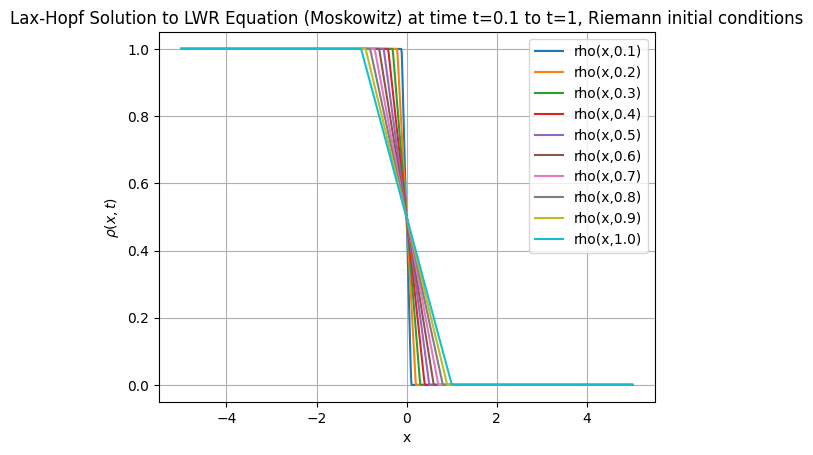

In [ ]:
# LWR Equation (Greenshields Flux)

# Greenshield Flux function for concave fundamental diagram
def greenshields_flux(rho, vmax=1.0, rho_max=1.0):
    return vmax * rho * (1 - rho / rho_max)

# inital conditions rho0 (Reimann problem with uL > uR)
def rho0(y):
    return 1.0 if y < 0.0 else 0.0

# Hamiltonian H(p) = - f(-p) for LWR equation
def H(p):
    return -greenshields_flux(-p)

# Legendre transform L(v) = sup_p [ p*v - H(p) ] for LWR equation
def L(V, p_search_min=-2.0, p_search_max=2.0, np_p=2001):
    P = np.linspace(p_search_min, p_search_max, np_p)
    H_vals = H(P)
    L_vals = np.empty_like(V, dtype=float)
    for i, v in enumerate(V):
        arg = P * v - H_vals
        L_vals[i] = np.max(arg)
    return L_vals, P

def helper_L(P):
    H_vals = H(P)
    def evaluate_L(v):
        v = np.atleast_1d(v)
        out = np.empty_like(v, dtype=float)
        for i, v_i in enumerate(v):
            out[i] = np.max(P * v_i - H_vals)
        return out if out.shape != (1,) else out[0]
    return evaluate_L, P

# initial conditions for density rho0
def N0(X, rho0, x0=0.0):
    """
    N0(x) such that N0_x = -rho0.
    N0(x0)=0
    N0(x) =  - integral_{x0}^{x} rho0(s) ds
    """
    Nx = len(X)
    dx = X[1] - X[0]
    rho_vals = np.array([rho0(x) for x in X])
    # cumulative integral using trapezoid
    integral = np.zeros_like(X)
    integral[0] = 0.0
    for i in range(1, Nx):
        integral[i] = integral[i-1] + 0.5*(rho_vals[i-1] + rho_vals[i]) * dx
    N0 = - (integral - np.interp(x0, X, integral))
    return N0, rho_vals

# Lax-Hopf formula for LWR equation on semi-infinite domain x>=0
def lax_hopf_lwr(X, t, N0, Y, evaluate_L):
    """
    X: space grid
    t: time
    N0: initial N0(y) for Y
    Y: discrete grid of candidate y-values
    evaluate_L: callable L(v) legendre transform
    """
    Nx = len(X)
    Ny = len(Y)
    dx = Y[1] - Y[0]

    # compute initial part: inf_y [ N0(y) + t L((x-y)/t) ]
    X = X.reshape((Nx,1))
    Y = Y.reshape((1,Ny))
    V = (X - Y) / t # shape (Nx, Ny)
    V_flat = V.ravel()
    L_flat = evaluate_L(V_flat)
    L = L_flat.reshape((Nx, Ny))
    candidates = N0.reshape((1,Ny)) + t * L # shape (Nx, Ny)
    return np.min(candidates, axis=1) # shape (Nx,)

# calculate density rho = -N_x from lax-hopf
def density(N_vals, X):
    dx = X[1] - X[0]
    Nx = len(X)
    rho = np.empty_like(N_vals)
    # N_x approx (N[i+1] - N[i-1])/(2dx) then rho = -N_x
    for i in range(Nx):
        if i == 0: # left boundary
            Nx_x = (N_vals[1] - N_vals[0]) / dx
        elif i == Nx-1: # right boundary
            Nx_x = (N_vals[-1] - N_vals[-2]) / dx
        else: # else
            Nx_x = (N_vals[i+1] - N_vals[i-1]) / (2*dx)
        rho[i] = -Nx_x
    return rho

# simulate Riemann problem on x in [-5,5]

# discretized spatial grid
X = np.linspace(-5, 5, 1001)
dx = X[1]-X[0]
Y = X.copy()

N0_vec, rho0_vals = N0(X, rho0, x0=0.0)
P = np.linspace(-3.0, 3.0, 2001)
evaluate_L, P_vals = helper_L(P)

plt.figure()
for t in [i / 10.0 for i in range(1, 11)]:
    Nxt = lax_hopf_lwr(X, t, N0_vec, Y, evaluate_L)
    rho_t = density(Nxt, X)

    plt.plot(X, rho_t, label=f'rho(x,{t})')
plt.grid(True)
plt.legend()
plt.xlabel('x')
plt.ylabel(r'$\rho(x,t)$')
plt.title('Lax-Hopf Solution to LWR Equation (Moskowitz) at time t=0.1 to t=1, Riemann initial conditions')
plt.show()

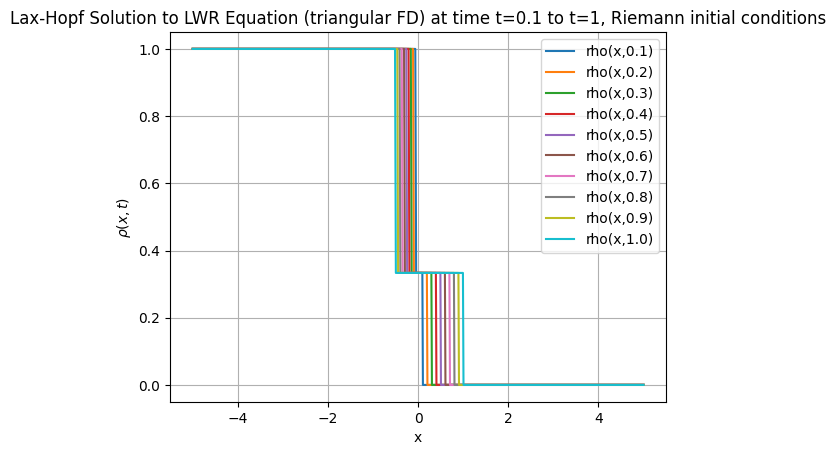

Lambda shock speed =  0.0


In [50]:
# LWR Equation (Triangular Flux)

# triangular flux
v_f = 1.0 # free-flow speed
w = 0.5 # congestion wave speed (positive)
rho_max = 1.0
rho_c = (w / (v_f + w)) * rho_max
q_max = v_f * rho_c

# Legendre transform L(v) = max(0, q_max - rho_c * v, -rho_max * v) for triangular FD
def L(v):
    v = np.asarray(v)
    return np.maximum.reduce([np.zeros_like(v), q_max - rho_c * v, -rho_max * v])

# initial conditions for density rho0
def N0(X, rho0, x0=0.0):
    dx = X[1] - X[0]
    rho_vals = np.array([rho0(x) for x in X])

    integral = np.zeros_like(X)
    integral[1:] = np.cumsum(0.5*(rho_vals[:-1] + rho_vals[1:])) * dx

    N0 = -(integral - np.interp(x0, X, integral))
    return N0, rho_vals

# Lax-Hopf formula for LWR equation with Triangular FD for flux
def lax_hopf_tri(X, t, N0, Y):
    """
    X: space grid
    t: time
    N0: initial N0(y) for Y
    Y: discrete grid of candidate y-values
    """
    Nx = len(X)
    Ny = len(Y)
    X = X.reshape((Nx,1))
    Y = Y.reshape((1,Ny))
    V = (X - Y) / t # shape (Nx,Ny)
    candidates = N0.reshape((1,Ny)) + (t * L(V)) # shape (Nx,Ny)
    return np.min(candidates, axis=1) # shape (Nx,)

# calculate density rho = -N_x from lax-hopf
def density(N_vals, X):
    dx = X[1] - X[0]
    dNdx = np.gradient(N_vals, dx)
    rho = -dNdx
    return rho

# simulate Riemann problem (rho_L=1, rho_R=0) on x in [-5,5]

# discretized spatial grid
X = np.linspace(-5, 5, 1601)
dx = X[1] - X[0]
Y = X.copy()

# Riemann initial condition
rhoL = 1.0
rhoR = 0.0

# inital conditions rho0 (Reimann problem with uL > uR)
def rho0(y):
    return rhoL if y < 0.0 else rhoR

N0_vec, rho0_vals = N0(X, rho0, x0=0.0)

plt.figure()
for t in [i / 10.0 for i in range(1, 11)]:
    Nxt = lax_hopf_tri(X, t, N0_vec, Y)
    rho_t = density(Nxt, X)

    plt.plot(X, rho_t, label=f'rho(x,{t})')
plt.grid(True)
plt.legend()
plt.xlabel('x')
plt.ylabel(r'$\rho(x,t)$')
plt.title('Lax-Hopf Solution to LWR Equation (triangular FD) at time t=0.1 to t=1, Riemann initial conditions')
plt.show()

# calculate lambda (shock speed)
def lambda_shock(rho):
    return min(v_f*rho, w*(rho_max - rho))

lam = (lambda_shock(rhoL) - lambda_shock(rhoR)) / (rhoL - rhoR)
print("Lambda shock speed = ", lam)